# Cleaning the model output

Having run the model, the next step is cleaning the model output so it matches the RCMIP submission protocol. 

In [1]:
import logging
import os
import os.path
import traceback

import pandas as pd
import openscm_units.unit_registry as ur
import xarray as xr
from scmdata import ScmRun

from pyrcmip.errors import ProtocolConsistencyError
from pyrcmip.validate import validate_submission, validate_submission_model_reported_metrics

In [2]:
OUTPUT_FILE = os.path.join("data", "output", "raw", "raw_model_output.nc")
OUTPUT_FILE

'data/output/raw/raw_model_output.nc'

In [3]:
METADATA_FILE = os.path.join("data", "output", "raw", "raw_metadata.csv")
METADATA_FILE

'data/output/raw/raw_metadata.csv'

In [4]:
raw_output = ScmRun.from_nc(OUTPUT_FILE)
raw_output

<scmdata.ScmRun (timeseries: 900, timepoints: 3250)>
Time:
	Start: 1750-01-01T00:00:00
	End: 4999-01-01T00:00:00
Meta:
	             model               scenario  ensemble_member  \
	0        idealised                1pctCO2                0   
	1        idealised         abrupt-0p5xCO2                0   
	2        idealised           abrupt-2xCO2                0   
	3        idealised           abrupt-4xCO2                0   
	4      unspecified             historical                0   
	..             ...                    ...              ...   
	895        AIM/CGE  ssp370-lowNTCF-gidden               11   
	896          GCAM4                 ssp434               11   
	897          GCAM4                 ssp460               11   
	898  REMIND-MAGPIE            ssp534-over               11   
	899  REMIND-MAGPIE                 ssp585               11   
	
	                        variable climate_model        unit region  
	0    Effective Radiative Forcing     two_layer       

## Preparing output for RCMIP

Depending on the model, this could require multiple steps or be fairly straight-forward. Using `pyrcmip`'s `validate` module, we can quickly get a summary of what is wrong with our data (and from there, determine what needs to change). 

In [5]:
try:
    validate_submission(raw_output)
except ProtocolConsistencyError:
    traceback.print_exc(limit=0, chain=False)

problems with variables in submission
Traceback (most recent call last):
  File "/Users/znicholls/Documents/AGCEC/RCMIP/pyrcmip/src/pyrcmip/validate/__init__.py", line 147, in validate_submission
    protocol_variables["variable"].tolist(),
  File "/Users/znicholls/Documents/AGCEC/RCMIP/pyrcmip/src/pyrcmip/validate/__init__.py", line 223, in validate_variables
    _validate_sets(vars_to_check, protocol_variables, "Variables")
  File "/Users/znicholls/Documents/AGCEC/RCMIP/pyrcmip/src/pyrcmip/validate/__init__.py", line 201, in _validate_sets
    error_str_id, sorted(not_included)
pyrcmip.errors.ProtocolConsistencyError: Variables do not match the RCMIP protocol:
['Surface Temperature|Lower', 'Surface Temperature|Upper']
problems converting units in submission
Traceback (most recent call last):
  File "/Users/znicholls/Documents/AGCEC/RCMIP/pyrcmip/src/pyrcmip/validate/__init__.py", line 179, in validate_submission
    out = convert_units_to_rcmip_units(submission, protocol_variables)
 

In our case, we have to do two steps (look at the lines that start with "problems"):

1. rename variables
1. convert the heat uptake units from W/m^2 to ZJ/yr by making an assumption about the Earth's surface area

The scenarios are already all correctly named. If a scenario was incorrectly named, we would get scenario problems in our error messages too, like below.

In [6]:
try:
    wrong_scenario = raw_output.filter(scenario="ssp119").copy()
    wrong_scenario["scenario"] = "Historical"
    validate_submission(wrong_scenario)
except ProtocolConsistencyError:
    traceback.print_exc(limit=0, chain=False)

problems with variables in submission
Traceback (most recent call last):
  File "/Users/znicholls/Documents/AGCEC/RCMIP/pyrcmip/src/pyrcmip/validate/__init__.py", line 147, in validate_submission
    protocol_variables["variable"].tolist(),
  File "/Users/znicholls/Documents/AGCEC/RCMIP/pyrcmip/src/pyrcmip/validate/__init__.py", line 223, in validate_variables
    _validate_sets(vars_to_check, protocol_variables, "Variables")
  File "/Users/znicholls/Documents/AGCEC/RCMIP/pyrcmip/src/pyrcmip/validate/__init__.py", line 201, in _validate_sets
    error_str_id, sorted(not_included)
pyrcmip.errors.ProtocolConsistencyError: Variables do not match the RCMIP protocol:
['Surface Temperature|Lower', 'Surface Temperature|Upper']
problems with scenarios in submission
Traceback (most recent call last):
  File "/Users/znicholls/Documents/AGCEC/RCMIP/pyrcmip/src/pyrcmip/validate/__init__.py", line 170, in validate_submission
    "scenario_id"
  File "/Users/znicholls/Documents/AGCEC/RCMIP/pyrcmip/s

### Renaming variables

In our case we make the very simple assumption that the upper surface temperature box is surface air temperature and that the lower box has no equivalent RCMIP variable so can simply be removed.

In [7]:
rcmip_compatible_output = raw_output.filter(
    variable="Surface Temperature|Lower", keep=False
)
rcmip_compatible_output.get_unique_meta("variable")

['Effective Radiative Forcing',
 'Heat Uptake',
 'Surface Air Ocean Blended Temperature Change',
 'Surface Temperature|Upper']

In [8]:
def rename_variable(v):
    if v == "Surface Temperature|Upper":
        return "Surface Air Temperature Change"
    
    return v

In [9]:
rcmip_compatible_output["variable"] = rcmip_compatible_output["variable"].apply(
    rename_variable
)
rcmip_compatible_output.get_unique_meta("variable")

['Effective Radiative Forcing',
 'Heat Uptake',
 'Surface Air Ocean Blended Temperature Change',
 'Surface Air Temperature Change']

### Converting heat uptake units

<AxesSubplot:xlabel='time', ylabel='W/m^2'>

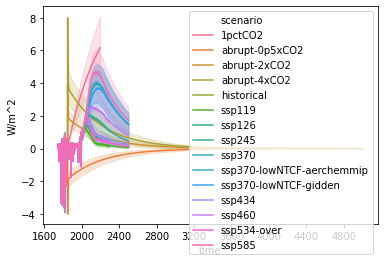

In [10]:
# starting point
rcmip_compatible_output.filter(variable="Heat Uptake").lineplot(ci="sd")

In [11]:
earth_surface_area = 510.1 * 10**6 * ur("km^2")
earth_surface_area

510100000.0 <Unit('kilometer ** 2')>

In [12]:
heat_uptake_converted = (
    rcmip_compatible_output.filter(variable="Heat Uptake") 
    * earth_surface_area
).convert_unit("ZJ / yr")
heat_uptake_converted

/Users/znicholls/Documents/AGCEC/RCMIP/pyrcmip/venv/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


<scmdata.ScmRun (timeseries: 180, timepoints: 3250)>
Time:
	Start: 1750-01-01T00:00:00
	End: 4999-01-01T00:00:00
Meta:
	             model               scenario  ensemble_member     variable  \
	180      idealised                1pctCO2                0  Heat Uptake   
	181      idealised         abrupt-0p5xCO2                0  Heat Uptake   
	182      idealised           abrupt-2xCO2                0  Heat Uptake   
	183      idealised           abrupt-4xCO2                0  Heat Uptake   
	184    unspecified             historical                0  Heat Uptake   
	..             ...                    ...              ...          ...   
	355        AIM/CGE  ssp370-lowNTCF-gidden               11  Heat Uptake   
	356          GCAM4                 ssp434               11  Heat Uptake   
	357          GCAM4                 ssp460               11  Heat Uptake   
	358  REMIND-MAGPIE            ssp534-over               11  Heat Uptake   
	359  REMIND-MAGPIE                 ssp585   

In [13]:
rcmip_compatible_output = rcmip_compatible_output.filter(
    variable="Heat Uptake", keep=False
).append(heat_uptake_converted)
rcmip_compatible_output

<scmdata.ScmRun (timeseries: 720, timepoints: 3250)>
Time:
	Start: 1750-01-01T00:00:00
	End: 4999-01-01T00:00:00
Meta:
	             model               scenario  ensemble_member  \
	0        idealised                1pctCO2                0   
	1        idealised         abrupt-0p5xCO2                0   
	2        idealised           abrupt-2xCO2                0   
	3        idealised           abrupt-4xCO2                0   
	4      unspecified             historical                0   
	..             ...                    ...              ...   
	895        AIM/CGE  ssp370-lowNTCF-gidden               11   
	896          GCAM4                 ssp434               11   
	897          GCAM4                 ssp460               11   
	898  REMIND-MAGPIE            ssp534-over               11   
	899  REMIND-MAGPIE                 ssp585               11   
	
	                           variable climate_model        unit region  
	0       Effective Radiative Forcing     two_layer 

In [14]:
# converted
rcmip_compatible_output.filter(variable="Heat Uptake").lineplot(ci="sd")

<AxesSubplot:xlabel='time', ylabel='ZJ / yr'>

## Validating the results

We can validate our submission by passing it through the `validate_submission` function once again. The result contains the submission with units converted to match RMCIP units.

In [15]:
rcmip_compatible_output = validate_submission(rcmip_compatible_output)
rcmip_compatible_output

<scmdata.ScmRun (timeseries: 720, timepoints: 3250)>
Time:
	Start: 1750-01-01T00:00:00
	End: 4999-01-01T00:00:00
Meta:
	             model               scenario  ensemble_member  \
	0        idealised                1pctCO2                0   
	1        idealised         abrupt-0p5xCO2                0   
	2        idealised           abrupt-2xCO2                0   
	3        idealised           abrupt-4xCO2                0   
	4      unspecified             historical                0   
	..             ...                    ...              ...   
	895        AIM/CGE  ssp370-lowNTCF-gidden               11   
	896          GCAM4                 ssp434               11   
	897          GCAM4                 ssp460               11   
	898  REMIND-MAGPIE            ssp534-over               11   
	899  REMIND-MAGPIE                 ssp585               11   
	
	                           variable climate_model   unit region  
	0       Effective Radiative Forcing     two_layer  W/m^

## Model reported metrics

Alongside our timeseries, we also need to report our model reported metrics. At this stage the only one which is requested is equilibrium climate sensitivity.

We start with the raw metadata we saved out previously.

In [16]:
raw_meta = pd.read_csv(METADATA_FILE)
raw_meta

model        scenario region  \
0      AIM/CGE          ssp370  World   
1      AIM/CGE          ssp370  World   
2      AIM/CGE          ssp370  World   
3      AIM/CGE          ssp370  World   
4      AIM/CGE          ssp370  World   
..         ...             ...    ...   
895  idealised  abrupt-0p5xCO2  World   
896  idealised  abrupt-0p5xCO2  World   
897  idealised  abrupt-0p5xCO2  World   
898  idealised  abrupt-0p5xCO2  World   
899  idealised  abrupt-0p5xCO2  World   

                                         variable        unit climate_model  \
0                     Effective Radiative Forcing       W/m^2     two_layer   
1                       Surface Temperature|Upper  delta_degC     two_layer   
2    Surface Air Ocean Blended Temperature Change  delta_degC     two_layer   
3                       Surface Temperature|Lower  delta_degC     two_layer   
4                                     Heat Uptake       W/m^2     two_layer   
..                                            ...         ...           ...   
895                   Effective Radiative Forcing       W/m^2     two_layer   
896                     Surface Temperature|Upper  delta_degC     two_layer   
897  Surface Air Ocean Blended Temperature Change  delta_degC     two_layer   
898                     Surface Temperature|Lower  delta_degC     two_layer   
899                                   Heat Uptake       W/m^2     two_layer   

     run_idx  lambda0 (watt / delta_degree_Celsius / meter ** 2)  \
0          0                                           2.666667    
1          0                                           2.666667    
2          0                                           2.666667    
3          0                                           2.666667    
4          0                                           2.666667    
..       ...                                                ...    
895       14                                           0.571429    
896       14                                           0.571429    
897       14                                           0.571429    
898       14                                           0.571429    
899       14                                           0.571429    

     eta (watt / delta_degree_Celsius / meter ** 2)  \
0                                               0.8   
1                                               0.8   
2                                               0.8   
3                                               0.8   
4                                               0.8   
..                                              ...   
895                                             0.8   
896                                             0.8   
897                                             0.8   
898                                             0.8   
899                                             0.8   

     a (watt / delta_degree_Celsius ** 2 / meter ** 2)  \
0                                                  0.0   
1                                                  0.0   
2                                                  0.0   
3                                                  0.0   
4                                                  0.0   
..                                                 ...   
895                                                0.0   
896                                                0.0   
897                                                0.0   
898                                                0.0   
899                                                0.0   

     efficacy (dimensionless)  dl (meter) mip_era  du (meter)     activity_id  \
0                         1.0        1200   CMIP6          50  not_applicable   
1                         1.0        1200   CMIP6          50  not_applicable   
2                         1.0        1200   CMIP6          50  not_applicable   
3                         1.0        1200   CMIP6          50  not_a

We can get a sense of what is wrong using the validation function.

In [17]:
try:
    validate_submission_model_reported_metrics(raw_meta)
except ProtocolConsistencyError:
    traceback.print_exc(limit=0, chain=False)

Traceback (most recent call last):
pyrcmip.errors.ProtocolConsistencyError: Input columns: {'unit', 'a (watt / delta_degree_Celsius ** 2 / meter ** 2)', 'eta (watt / delta_degree_Celsius / meter ** 2)', 'scenario', 'climate_model', 'variable', 'lambda0 (watt / delta_degree_Celsius / meter ** 2)', 'efficacy (dimensionless)', 'dl (meter)', 'du (meter)', 'activity_id', 'ensemble_member', 'region', 'model', 'run_idx', 'ecs (K)', 'mip_era'}. Expected columns: {'unit', 'value', 'climate_model', 'ensemble_member', 'RCMIP name'}.


Now we convert to the RCMIP format.

In [18]:
rcmip_model_reported = []
for ensemble_member, df in raw_meta.groupby(["ensemble_member"]):
    ecs = df["ecs (K)"].unique()
    assert len(ecs) == 1
    ecs = ecs[0]
    climate_model = df["climate_model"].unique()
    assert len(climate_model) == 1
    climate_model = climate_model[0]
    to_append = {
        "unit": "K",
        "value": ecs,
        "ensemble_member": ensemble_member,
        "climate_model": climate_model,
        "RCMIP name": "Equilibrium Climate Sensitivity",
    }
    rcmip_model_reported.append(to_append)

rcmip_model_reported = pd.DataFrame(rcmip_model_reported)
rcmip_model_reported

unit  value  ensemble_member climate_model                       RCMIP name
0     K    1.5                0     two_layer  Equilibrium Climate Sensitivity
1     K    2.0                1     two_layer  Equilibrium Climate Sensitivity
2     K    2.5                2     two_layer  Equilibrium Climate Sensitivity
3     K    3.0                3     two_layer  Equilibrium Climate Sensitivity
4     K    3.5                4     two_layer  Equilibrium Climate Sensitivity
5     K    4.0                5     two_layer  Equilibrium Climate Sensitivity
6     K    4.5                6     two_layer  Equilibrium Climate Sensitivity
7     K    5.0                7     two_layer  Equilibrium Climate Sensitivity
8     K    5.5                8     two_layer  Equilibrium Climate Sensitivity
9     K    6.0                9     two_layer  Equilibrium Climate Sensitivity
10    K    6.5               10     two_layer  Equilibrium Climate Sensitivity
11    K    7.0               11     two_layer  Equilibrium Climate Sensitivity

In [19]:
rcmip_model_reported = validate_submission_model_reported_metrics(rcmip_model_reported)
rcmip_model_reported

unit  value  ensemble_member climate_model                       RCMIP name
0     K    1.5                0     two_layer  Equilibrium Climate Sensitivity
1     K    2.0                1     two_layer  Equilibrium Climate Sensitivity
2     K    2.5                2     two_layer  Equilibrium Climate Sensitivity
3     K    3.0                3     two_layer  Equilibrium Climate Sensitivity
4     K    3.5                4     two_layer  Equilibrium Climate Sensitivity
5     K    4.0                5     two_layer  Equilibrium Climate Sensitivity
6     K    4.5                6     two_layer  Equilibrium Climate Sensitivity
7     K    5.0                7     two_layer  Equilibrium Climate Sensitivity
8     K    5.5                8     two_layer  Equilibrium Climate Sensitivity
9     K    6.0                9     two_layer  Equilibrium Climate Sensitivity
10    K    6.5               10     two_layer  Equilibrium Climate Sensitivity
11    K    7.0               11     two_layer  Equilibrium Climate Sensitivity

## Saving to disk

At this point we have a dataset and model reported dataframe which are ready for submission. We now need to save them to disk so that they can then be submitted.

### Model reported metrics

Firstly we write our model reported csv to disk.

In [20]:
output_file_model_reported_csv = os.path.join("data", "output", "processed", "rcmip_model_reported_metrics.csv")

if not os.path.isdir(os.path.dirname(output_file_model_reported_csv)):
    os.makedirs(os.path.dirname(output_file_model_reported_csv))
    
rcmip_model_reported.to_csv(output_file_model_reported_csv, index=False)
output_file_model_reported_csv

'data/output/processed/rcmip_model_reported_metrics.csv'

### Metadata

Next we write our model metadata to disk.

In [21]:
cm = rcmip_model_reported["climate_model"].unique()[0]
rcmip_model_metadata = pd.DataFrame([{
    "climate_model": "{}".format(cm),
    "climate_model_name": cm,
    "climate_model_version": "example",
    "climate_model_configuration_label": "example-config",
    "climate_model_configuration_description": "Example configuration for demonstrating RCMIP submission",
    "project": "RCMIP",
    "name_of_person": "Zebedee Nicholls <zebedee.nicholls@climate-energy-college.org>",
    "literature_reference": "https://github.com/openscm/openscm-twolayermodel",
}])
rcmip_model_metadata

climate_model climate_model_name climate_model_version  \
0     two_layer          two_layer               example   

  climate_model_configuration_label  \
0                    example-config   

             climate_model_configuration_description project  \
0  Example configuration for demonstrating RCMIP ...   RCMIP   

                                      name_of_person  \
0  Zebedee Nicholls <zebedee.nicholls@climate-ene...   

                               literature_reference  
0  https://github.com/openscm/openscm-twolayermodel

In [22]:
output_file_metadata_csv = os.path.join("data", "output", "processed", "rcmip_model_metadata.csv")
rcmip_model_metadata.to_csv(output_file_metadata_csv, index=False)
output_file_metadata_csv

'data/output/processed/rcmip_model_metadata.csv'

### Timeseries

Next we write our timeseries to disk. Here we present two possible options: csv and netCDF.

#### csv

The first option is to save the output to disk in `scmdata`'s csv format. Here we show how to do this using `ScmRun`, if you write code to do this in another way (particularly in another programming language), please make a merge request into the pyrcmip repository so we can ensure that it is shared.

In [23]:
output_file_csv = os.path.join("data", "output", "processed", "rcmip_model_output.csv")
output_file_csv

'data/output/processed/rcmip_model_output.csv'

In [24]:
if not os.path.isdir(os.path.dirname(output_file_csv)):
    os.makedirs(os.path.dirname(output_file_csv))

In [25]:
csv_timeseries = rcmip_compatible_output.timeseries(time_axis="year").reset_index()
csv_timeseries

time          model               scenario  ensemble_member  \
0         idealised                1pctCO2                0   
1         idealised         abrupt-0p5xCO2                0   
2         idealised           abrupt-2xCO2                0   
3         idealised           abrupt-4xCO2                0   
4       unspecified             historical                0   
..              ...                    ...              ...   
715         AIM/CGE  ssp370-lowNTCF-gidden               11   
716           GCAM4                 ssp434               11   
717           GCAM4                 ssp460               11   
718   REMIND-MAGPIE            ssp534-over               11   
719   REMIND-MAGPIE                 ssp585               11   

time                        variable climate_model   unit region      1750  \
0        Effective Radiative Forcing     two_layer  W/m^2  World       NaN   
1        Effective Radiative Forcing     two_layer  W/m^2  World       NaN   
2        Effective Radiative Forcing     two_layer  W/m^2  World       NaN   
3        Effective Radiative Forcing     two_layer  W/m^2  World       NaN   
4        Effective Radiative Forcing     two_layer  W/m^2  World  0.259367   
..                               ...           ...    ...    ...       ...   
715   Surface Air Temperature Change     two_layer      K  World  0.000000   
716   Surface Air Temperature Change     two_layer      K  World  0.000000   
717   Surface Air Temperature Change     two_layer      K  World  0.000000   
718   Surface Air Temperature Change     two_layer      K  World  0.000000   
719   Surface Air Temperature Change     two_layer      K  World  0.000000   

time      1751      1752  ...  4990  4991  4992  4993  4994  4995  4996  4997  \
0          NaN       NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1          NaN       NaN  ...  -4.0  -4.0  -4.0  -4.0  -4.0  -4.0  -4.0  -4.0   
2          NaN       NaN  ...   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   
3          NaN       NaN  ...   8.0   8.0   8.0   8.0   8.0   8.0   8.0   8.0   
4     0.242788  0.214656  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
..         ...       ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   
715   0.039153  0.067698  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
716   0.039153  0.067698  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
717   0.039153  0.067698  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
718   0.039153  0.067698  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
719   0.039153  0.067698  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

time  4998  4999  
0      NaN   NaN  
1     -4.0  -4.0  
2      4.0   4.0  
3      8.0   8.0  
4      NaN   NaN  
..     ...   ...  
715    NaN   NaN  
716    NaN   NaN  
717    NaN   NaN  
718    NaN   NaN  
719    NaN   NaN  

[720 rows x 3257 columns]

In [26]:
csv_timeseries.to_csv(output_file_csv, index=False)
output_file_csv

'data/output/processed/rcmip_model_output.csv'

We can get a kind of preview of the output format below.

In [27]:
!head -2 data/output/processed/rcmip_model_output.csv

model,scenario,ensemble_member,variable,climate_model,unit,region,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763,1764,1765,1766,1767,1768,1769,1770,1771,1772,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782,1783,1784,1785,1786,1787,1788,1789,1790,1791,1792,1793,1794,1795,1796,1797,1798,1799,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936

### gzip csv

If we want, we can also gzip the csv.

In [28]:
output_file_csv_gzipped = output_file_csv.replace(".csv", ".csv.gz")
output_file_csv_gzipped

'data/output/processed/rcmip_model_output.csv.gz'

In [29]:
csv_timeseries.to_csv(output_file_csv_gzipped, compression="gzip", index=False)
output_file_csv_gzipped

'data/output/processed/rcmip_model_output.csv.gz'

#### netCDF

The second option is to save the output to disk in `scmdata`'s netCDF format. Here we show how to do this using `ScmRun`, if you write code to do this in another way (particularly in another programming language), please make a merge request into the pyrcmip repository so we can ensure that it is shared.

- save data
- show the output from ncdump

In [30]:
output_file_nc = output_file_csv.replace(".csv", ".nc")
output_file_nc

'data/output/processed/rcmip_model_output.nc'

In [31]:
rcmip_compatible_output.to_nc(
    output_file_nc, 
    dimensions=("scenario", "ensemble_member"),
    extras=("model",),
)
output_file_nc

'data/output/processed/rcmip_model_output.nc'

`xarray` can then give us a quick preview (if you have it installed).

In [32]:
xr.load_dataset(output_file_nc)

<xarray.Dataset>
Dimensions:                                       (ensemble_member: 12, scenario: 15, time: 3250)
Coordinates:
  * time                                          (time) float64 -6.942e+09 ....
  * scenario                                      (scenario) object '1pctCO2'...
  * ensemble_member                               (ensemble_member) int64 0 ....
Data variables:
    model                                         (scenario, ensemble_member) object ...
    Effective_Radiative_Forcing                   (scenario, ensemble_member, time) float64 ...
    Heat_Uptake                                   (scenario, ensemble_member, time) float64 ...
    Surface_Air_Ocean_Blended_Temperature_Change  (scenario, ensemble_member, time) float64 ...
    Surface_Air_Temperature_Change                (scenario, ensemble_member, time) float64 ...
Attributes:
    created_at:        2020-08-05T06:21:36.718176
    _scmdata_version:  0.6.3